### Imports

In [12]:
import torch
from torch import nn, optim
import torchvision.transforms.functional as TF

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from os import listdir
import os
from os.path import join
import cv2
import numpy as np

import matplotlib.pyplot as plt
from random import randint

png = './data/train/img/1803201916/img_00000000/1803201916-00000117.png'
if os.path.exists(png):
    _ = cv2.imread(png)
    cv2.imwrite(png[:-4]+'.jpg', _)
    os.remove(png)


### Visualization

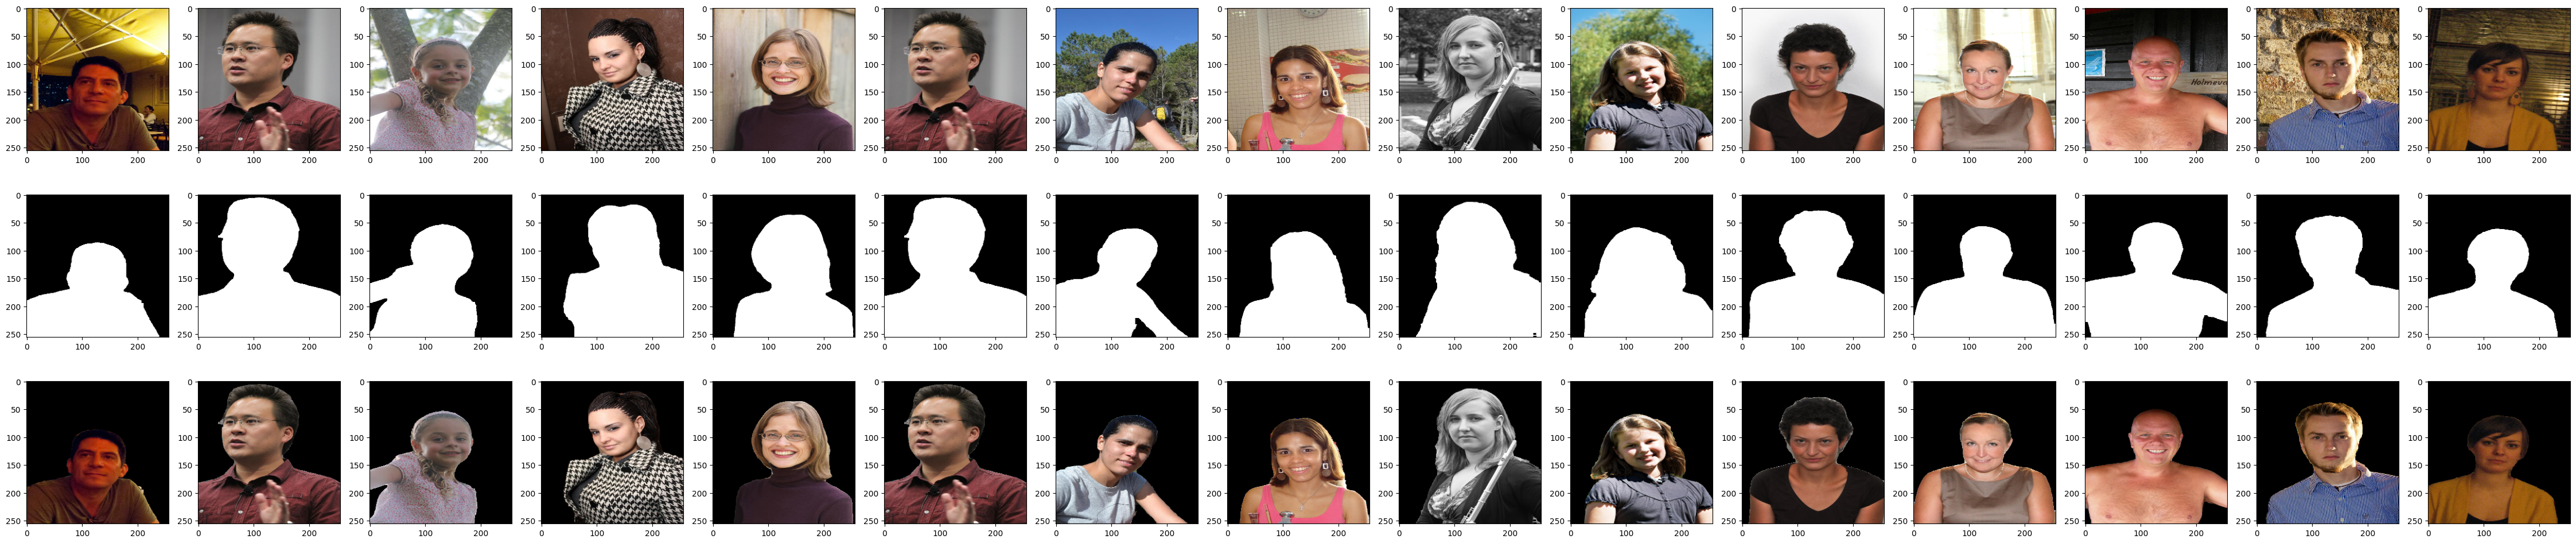

In [3]:
x_base = 'data/val/img/1803290444/img_00000000/'
y_base = x_base.replace('img', 'mask')

tokens = listdir(x_base)
num = min(15, len(tokens))

fig, axes = plt.subplots(3, num, figsize=(num*3, 10))

for i in range(num):
    idx = randint(0, len(tokens))
    img = cv2.cvtColor(cv2.imread(x_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) # w, h
    
    msk = cv2.cvtColor(cv2.imread(y_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    msk = cv2.resize(msk, (256, 256)) # w, h

    res = cv2.bitwise_and(img, msk)

    axes[0, i].imshow(img)
    axes[1, i].imshow(msk)
    axes[2, i].imshow(res)


plt.tight_layout()
plt.show()


### Model

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    in_channels=feature*2, out_channels=feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottle_neck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottle_neck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                # height x width
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat([skip_connection, x], dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


### Dataset

In [5]:
class SegDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.images = []
        self.transform = transform

        for sub1 in listdir(join(base_dir, 'img')):
            for sub2 in listdir(join(base_dir, 'img', sub1)):
                for fn in listdir(join(base_dir, 'img', sub1, sub2)):
                    self.images.append(join(base_dir, 'img', sub1, sub2, fn))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.images[index].replace('img', 'mask'))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        return image / 255, mask / 255


### Utils

In [52]:
def load_checkpoint(checkpoint, model):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def get_loaders(
        train_dir,
        val_dir,
        batch_size,
        train_transform,
        val_transform,
        num_workers=2,
        pin_memory=True
):
    train_ds = SegDataset(
        base_dir=train_dir,
        transform=train_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
        drop_last=True,
    )

    val_ds = SegDataset(
        base_dir=val_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
        drop_last=True,
    )

    return train_loader, val_loader

def get_mean_std(loader):
    channels_sum, channels_squared_sum, n_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data.float(), dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data.float()**2, dim=[0, 2, 3])
        n_batches += 1

    mean = channels_sum / n_batches
    std = ((channels_squared_sum / n_batches) - mean**2) ** .5
    return mean, std

def model_eval(loader, model, device):
    n_correct = 0
    n_pixels = 0
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.unsqueeze(1).to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > .5).float()

            n_correct += (preds == y).sum()
            n_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / ((preds+y).sum() + 1e-8)
    
    print(f'Accuracy: {(n_correct / n_pixels) * 100}, Dice-Score: {dice_score/len(loader)}')
    model.train()


### Train

In [63]:
# epochs: 1 + 3 + 3 + 1 + 2.
LR = 1e-4
BATCH_SIZE = 20
NUM_WORKERS = 2 # >> nproc or lscpu
PIN_MEMORY = True
LOAD_MODEL = True
NUM_EPOCHS = 2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_IMAGE_DIR = './data/train/'
VAL_IMAGE_DIR = './data/val/'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for data, targets in loop:
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            preds = model(data)
            loss = loss_fn(preds, targets)
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.5),
        A.Rotate(limit=45, p=.5),
        A.HorizontalFlip(p=.3),
        A.VerticalFlip(p=.2),
        A.RandomFog(fog_coef_lower=0.5, p=.2),
        A.RandomRain(p=.2),
        A.Sharpen(p=.2),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2()
    ])

    model = UNet().to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_loader, val_loader = get_loaders(
        TRAIN_IMAGE_DIR,
        VAL_IMAGE_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load('checkpoint.pth.tar'), model)
    
    model.train()
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint)

        print('Epoch:', epoch, end=', ')
        model_eval(val_loader, model, DEVICE)

main()


=> Loading checkpoint


100%|██████████| 645/645 [05:19<00:00,  2.02it/s, loss=0.062]


=> Saving checkpoint
Epoch: 0, Accuracy: 97.38272094726562, Dice-Score: 0.9814472794532776


100%|██████████| 645/645 [05:17<00:00,  2.03it/s, loss=0.0579]


=> Saving checkpoint
Epoch: 1, Accuracy: 97.40828704833984, Dice-Score: 0.9816039204597473


### Testing model performance/accuracy

=> Loading checkpoint


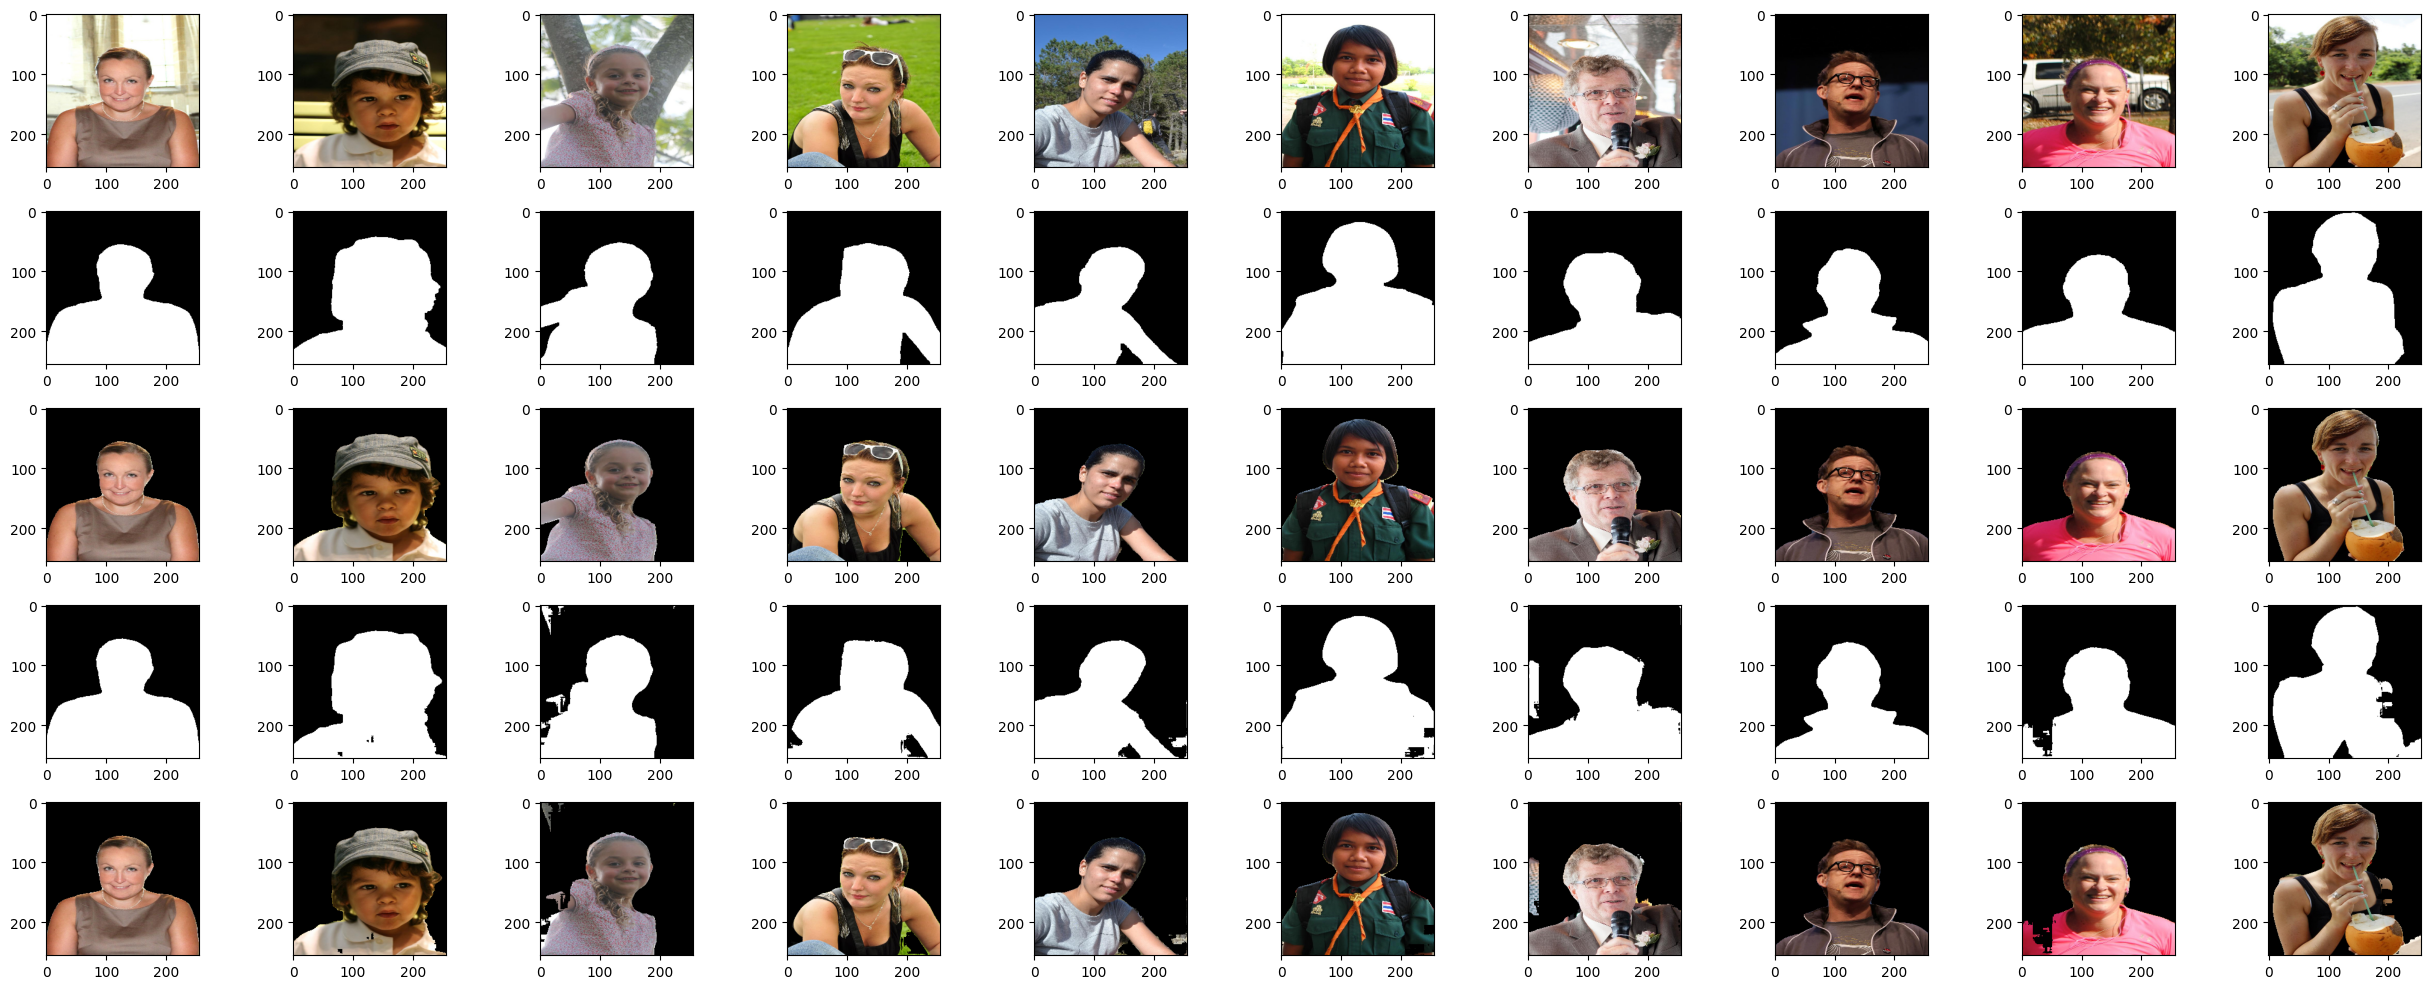

In [65]:
# load model
model = UNet()
load_checkpoint(torch.load('checkpoint.pth.tar'), model)
model.eval()

# test data loader
val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2()
])

val_ds = SegDataset(
    base_dir='./data/val/',
    transform=val_transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=10,
    num_workers=2,
    pin_memory=False,
    shuffle=True,
)

for x, y in val_loader:
    break

with torch.no_grad():
    preds = model(x)

fig, axes = plt.subplots(5, 10, figsize=(25, 10))

for idx, (img, mask, pred) in enumerate(zip(x, y, preds)):
    img = (np.transpose(img.numpy(), (1, 2, 0)) * 255).astype('uint8')
    mask = (cv2.cvtColor(mask.numpy(), cv2.COLOR_GRAY2RGB) * 255).astype('uint8')
    pred = (torch.sigmoid(pred.detach()) > .5).float().numpy().squeeze()
    pred = (cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB) * 255).astype('uint8')

    truth_res = cv2.bitwise_and(img, mask)
    pred_res = cv2.bitwise_and(img, pred)

    axes[0, idx].imshow(img)
    axes[1, idx].imshow(mask)
    axes[2, idx].imshow(truth_res)
    axes[3, idx].imshow(pred)
    axes[4, idx].imshow(pred_res)

plt.tight_layout()
plt.show()


### Save the model

In [80]:
!ls -Flash
# model = UNet()
# load_checkpoint(torch.load('checkpoint.pth.tar'), model)
# torch.save(model, 'unet_bg_seg_model_v2.pth')

# !zip unet_bg_seg_model_v2.pth.zip unet_bg_seg_model_v2.pth

total 1.4G
4.0K drwxr-xr-x 1 root root 4.0K May  2 15:06 ./
4.0K drwxr-xr-x 1 root root 4.0K May  2 11:58 ../
356M -rw-r--r-- 1 root root 356M May  2 14:35 checkpoint.pth.tar
4.0K drwxr-xr-x 4 root root 4.0K Apr 28 13:35 .config/
4.0K drwxr-xr-x 4 1000 1000 4.0K May  2 12:00 data/
754M -rw-r--r-- 1 root root 754M May  2 11:59 data.zip
4.0K drwx------ 5 root root 4.0K May  2 14:48 drive/
4.0K drwxr-xr-x 2 root root 4.0K May  2 15:05 .ipynb_checkpoints/
4.0K drwxr-xr-x 1 root root 4.0K Apr 28 13:35 sample_data/
119M -rw-r--r-- 1 root root 119M May  2 14:53 unet_bg_seg_model_v2.pth
110M -rw-r--r-- 1 root root 110M May  2 15:06 unet_bg_seg_model_v2.pth.zip


### Experimentation on different augmentations

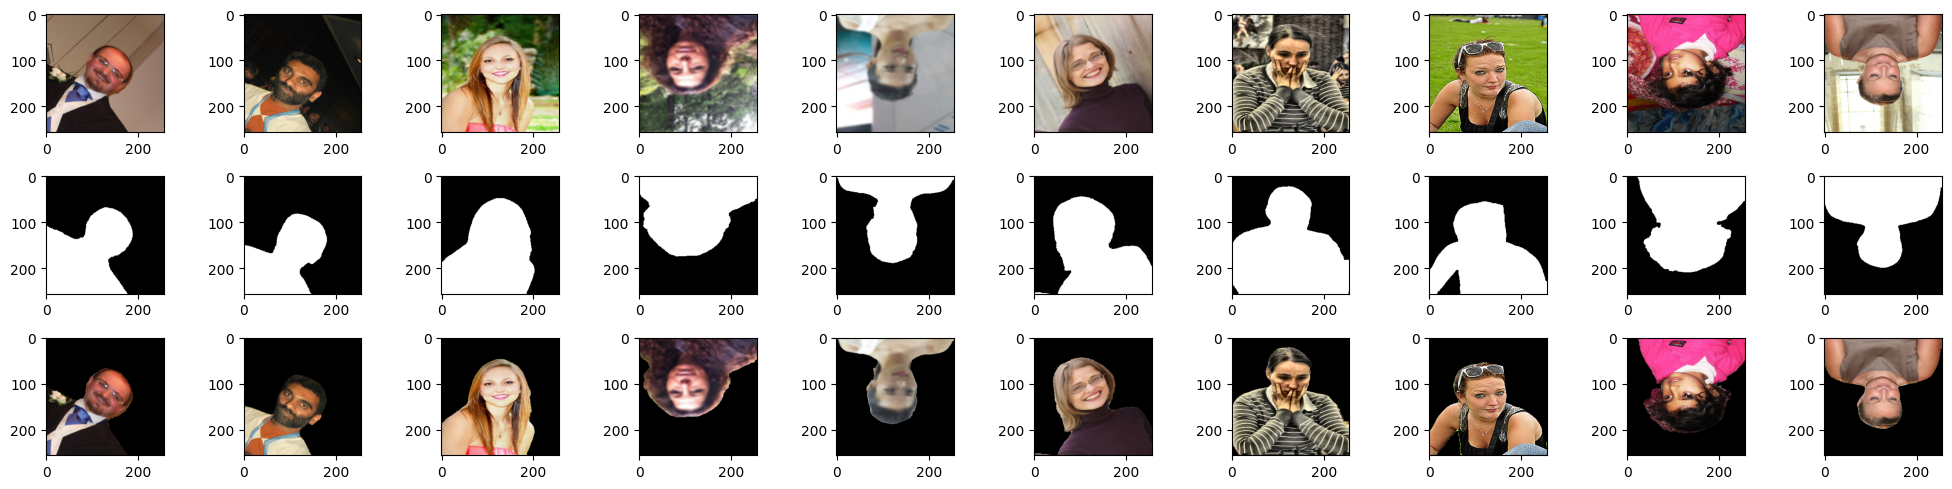

In [51]:
val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.3),
    A.Rotate(limit=45, p=.7),
    A.HorizontalFlip(p=.6),
    A.VerticalFlip(p=.5),
    A.RandomFog(fog_coef_lower=0.5, p=.15),
    A.RandomRain(p=.15),
    A.Sharpen(p=.2),
    ToTensorV2()
])

val_ds = SegDataset(
    base_dir='./data/val/',
    transform=val_transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=10,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
    drop_last=True
)

for x, y in val_loader:
    break

fig, axes = plt.subplots(3, 10, figsize=(20, 5))

for idx, (img, mask) in enumerate(zip(x, y)):
    img = (np.transpose(img.numpy(), (1, 2, 0)) * 255).astype('uint8')
    mask = (cv2.cvtColor(mask.numpy(), cv2.COLOR_GRAY2RGB) * 255).astype('uint8')

    res = cv2.bitwise_and(img, mask)

    axes[0, idx].imshow(img)
    axes[1, idx].imshow(mask)
    axes[2, idx].imshow(res)

plt.tight_layout()
plt.show()


In [70]:
# !mkdir ./drive/MyDrive/Models
!mv ./unet_bg_seg_model_v2.pth ./drive/MyDrive/unet_bg_seg_model_v2.pth